## Preamble

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
plt.style.use('ggplot')
import qsharp
qsharp.packages.add("Microsoft.Quantum.MachineLearning::0.28.302812")
qsharp.reload()

Preparing Q# environment...


Adding package Microsoft.Quantum.MachineLearning::0.28.302812.

Reloading workspace.

In [2]:
from Microsoft.Quantum.Samples import (
    TrainHalfMoonModel, ValidateHalfMoonModel, ClassifyHalfMoonModel
)

In [3]:
%matplotlib inline

## Data

In [4]:
with open('train_test_split.json') as f:
    data = json.load(f)

In [5]:
data

{'TrainingData': {'Features': [[3.0, 3.0, 3.0, 2.0, 0.0, 0.0],
   [2.0, 3.0, 1.0, 1.0, 2.0, 2.0],
   [1.0, 1.0, 3.0, 0.0, 0.0, 0.0],
   [0.0, 2.0, 2.0, 0.0, 1.0, 2.0],
   [0.0, 2.0, 1.0, 0.0, 1.0, 1.0],
   [0.0, 2.0, 2.0, 2.0, 2.0, 0.0],
   [3.0, 1.0, 3.0, 2.0, 0.0, 1.0],
   [0.0, 2.0, 1.0, 0.0, 1.0, 2.0],
   [2.0, 3.0, 1.0, 2.0, 0.0, 0.0],
   [2.0, 1.0, 1.0, 1.0, 0.0, 1.0],
   [3.0, 0.0, 0.0, 2.0, 2.0, 0.0],
   [0.0, 1.0, 2.0, 0.0, 2.0, 1.0],
   [2.0, 2.0, 0.0, 2.0, 0.0, 0.0],
   [2.0, 2.0, 3.0, 0.0, 0.0, 2.0],
   [2.0, 2.0, 1.0, 0.0, 2.0, 2.0],
   [2.0, 0.0, 0.0, 0.0, 2.0, 2.0],
   [1.0, 2.0, 0.0, 1.0, 2.0, 1.0],
   [2.0, 3.0, 0.0, 1.0, 0.0, 0.0],
   [0.0, 0.0, 1.0, 2.0, 0.0, 1.0],
   [0.0, 0.0, 1.0, 2.0, 1.0, 0.0],
   [1.0, 3.0, 0.0, 1.0, 1.0, 2.0],
   [2.0, 2.0, 2.0, 2.0, 1.0, 1.0],
   [0.0, 3.0, 2.0, 0.0, 0.0, 2.0],
   [2.0, 0.0, 1.0, 1.0, 2.0, 0.0],
   [1.0, 3.0, 3.0, 0.0, 2.0, 2.0],
   [0.0, 1.0, 3.0, 2.0, 2.0, 0.0],
   [2.0, 1.0, 3.0, 1.0, 2.0, 0.0],
   [2.0, 2.0, 1.0, 1.0, 1.0

## Training

In [6]:
parameter_starting_points = [
    [0.060057, 3.00522,  2.03083,  0.63527,  1.03771, 1.27881, 4.10186,  5.34396],
    [0.586514, 3.371623, 0.860791, 2.92517,  1.14616, 2.99776, 2.26505,  5.62137],
    [1.69704,  1.13912,  2.3595,   4.037552, 1.63698, 1.27549, 0.328671, 0.302282],
    [5.21662,  6.04363,  0.224184, 1.53913,  1.64524, 4.79508, 1.49742,  1.545]
 ]

In [7]:
(parameters, bias) = TrainHalfMoonModel.simulate(
    trainingVectors=data['TrainingData']['Features'],
    trainingLabels=data['TrainingData']['Labels'],
    initialParameters=parameter_starting_points,
    verbose=True
)

KeyboardInterrupt: 

## Validation

In [7]:
miss_rate = ValidateHalfMoonModel.simulate(
    validationVectors=data['ValidationData']['Features'],
    validationLabels=data['ValidationData']['Labels'],
    parameters=parameters, bias=bias
)

print(f"Miss rate: {miss_rate:0.2%}")

Miss rate: 13.33%


## Plotting

Classify the validation so that we can plot it.

In [8]:
actual_labels = data['ValidationData']['Labels']
classified_labels = ClassifyHalfMoonModel.simulate(
    samples=data['ValidationData']['Features'],
    parameters=parameters, bias=bias,
    tolerance=0.005, nMeasurements=10_000
)

To plot samples, it's helpful to have colors for each.
We'll plot four cases:
- actually 0, classified as 0
- actually 0, classified as 1
- actually 1, classified as 1
- actually 1, classified as 0


In [9]:
cases = [(0, 0), (0, 1), (1, 1), (1, 0)]

We can use these cases to define markers and colormaps for plotting.

In [10]:
markers = [
    '.' if actual == classified else 'x'
    for (actual, classified) in cases
]

In [11]:
colormap = cmx.ScalarMappable(colors.Normalize(vmin=0, vmax=len(cases) - 1))
colors = [colormap.to_rgba(idx_case) for (idx_case, case) in enumerate(cases)]

It's also really helpful to have the samples as a NumPy array so that we
can find masks for each of the four cases.

In [12]:
samples = np.array(data['ValidationData']['Features'])

Finally, we loop over the cases above and plot the samples that match each.

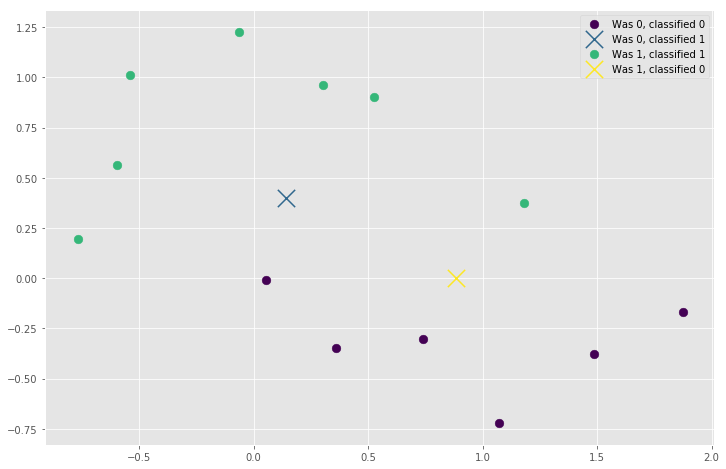

In [13]:
plt.figure(figsize=(12, 8))
for (idx_case, ((actual, classified), marker, color)) in enumerate(zip(cases, markers, colors)):
    mask = np.logical_and(np.equal(actual_labels, actual), np.equal(classified_labels, classified))
    if not np.any(mask): continue
    plt.scatter(
        samples[mask, 0], samples[mask, 1],
        label=f"Was {actual}, classified {classified}",
        marker=marker, s=300, c=[color],
    )
plt.legend()

## Epilogue

In [14]:
qsharp.component_versions()

{'iqsharp': LooseVersion ('0.12.20072031'),
 'Jupyter Core': LooseVersion ('1.4.0.0'),
 '.NET Runtime': LooseVersion ('.NETCoreApp,Version=v3.1'),
 'qsharp': LooseVersion ('0.12.2007.2031')}